In [1]:
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [3]:
data = data.iloc[:55000, :]

english = data['english']
french = data['french']

In [4]:
print("Length of english sentence:", len(english))
print("Length of french sentence:", len(french))

Length of english sentence: 55000
Length of french sentence: 55000


In [5]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]
print('After removing punctuation')
print('English word is: ', english[100])
print('-'*20)
print('French word is: ', french[100])

After removing punctuation
English word is:  Come in
--------------------
French word is:  Entre 


# New Section

In [6]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print('Convert all examples to lowercase')
print('English word is: ', english[100])
print('-'*20)
print('French word is: ', french[100])

Convert all examples to lowercase
English word is:  come in
--------------------
French word is:  entre 


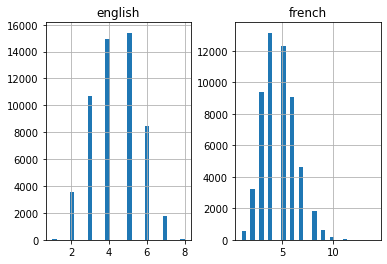

In [7]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [8]:
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, RepeatVector, Dropout, Bidirectional, Flatten

In [9]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

In [10]:
english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

In [11]:
word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 6908
Size of french vocab: 15743


In [12]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 8
Max length of french sentence: 14


In [13]:
english = pd.Series(english).to_frame('english')
french = pd.Series(french).to_frame('french')

dummy_df = pd.concat([english, french], axis=1)
train, test = train_test_split(dummy_df, test_size=0.1, random_state=42)

train_english = train.english.values
train_french = train.french.values

test_english = test.english.values
test_french = test.french.values

In [14]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [15]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, train_english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, train_french)

# test_english = encode_sequences(english_tokenizer, max_len_eng, test_english)
test_french = encode_sequences(french_tokenizer, max_len_fre, test_french)

In [16]:
print("english sentences have the same length :", max_len_eng)
print(eng_seq[15])
print(eng_seq[78])
print('-'*20)
print("french sentences have the same length :", max_len_fre)
print(fre_seq[86])
print(fre_seq[145])

english sentences have the same length : 8
[3205    5  980 6052    0    0    0    0]
[ 12 339 102   0   0   0   0   0]
--------------------
french sentences have the same length : 14
[   26   309     3   766    12 13565     0     0     0     0     0     0
     0     0]
[ 19  21 324 112   0   0   0   0   0   0   0   0   0   0]


In [19]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4)))
    model.add(Dropout(0.3))
    model.add(RepeatVector(out_timestep))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [20]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 128)

In [21]:
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=rms, metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 128)           1863552   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 256)            394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 256)            0         
_________________________________________________________________
dense (Dense)                (None, 8, 6909)           1

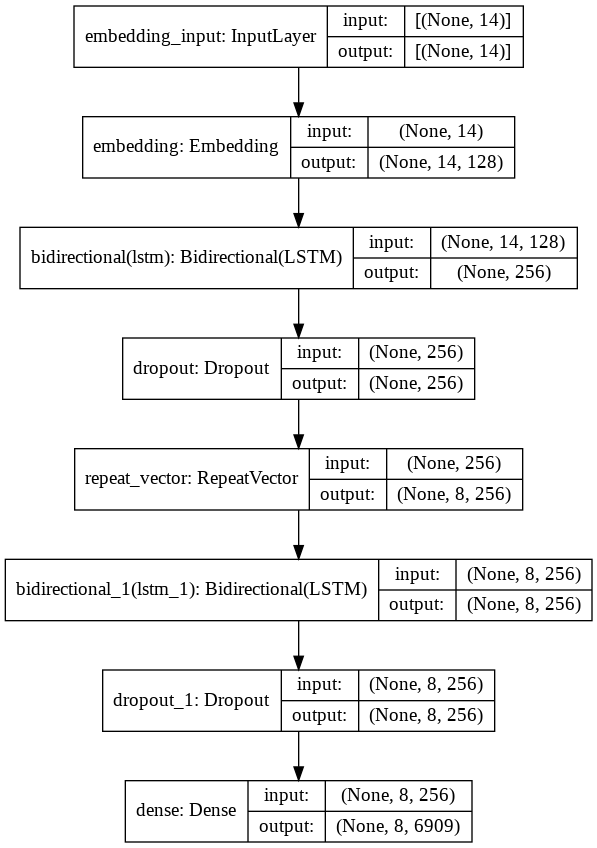

In [26]:
plot_model(model, show_shapes=True)

In [ ]:
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
eng_seq = eng_seq.reshape(eng_seq.shape[0], eng_seq.shape[1], 1)
history = model.fit(fre_seq, eng_seq, batch_size=1024, epochs=30, verbose=1, validation_split=0.05, shuffle=True, callbacks=[checkpoint])

Epoch 1/30
46/46 [==============================] - 175s 4s/step - loss: 4.1204 - accuracy: 0.4497 - val_loss: 3.3151 - val_accuracy: 0.4963

Epoch 00001: val_accuracy improved from -inf to 0.49631, saving model to weights-improvement.hdf5
Epoch 2/30
46/46 [==============================] - 168s 4s/step - loss: 3.0881 - accuracy: 0.5246 - val_loss: 2.8484 - val_accuracy: 0.5533

Epoch 00002: val_accuracy improved from 0.49631 to 0.55328, saving model to weights-improvement.hdf5
Epoch 3/30
46/46 [==============================] - 168s 4s/step - loss: 2.7198 - accuracy: 0.5634 - val_loss: 2.5367 - val_accuracy: 0.5888

Epoch 00003: val_accuracy improved from 0.55328 to 0.58884, saving model to weights-improvement.hdf5
Epoch 4/30
46/46 [==============================] - 168s 4s/step - loss: 2.4555 - accuracy: 0.5889 - val_loss: 2.3613 - val_accuracy: 0.6098

Epoch 00004: val_accuracy improved from 0.58884 to 0.60980, saving model to weights-improvement.hdf5
Epoch 5/30
46/46 [=============

In [17]:
from google.colab import files
#files.download('/content/weights-improvement.hdf5')

In [27]:
checkpoint_path = '/content/weights-improvement.hdf5'
model.load_weights(checkpoint_path)

OSError: ignored

In [ ]:
filepath_60="weights-improvement_to60.hdf5"
checkpoint_to60 = ModelCheckpoint(filepath_60, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(fre_seq, eng_seq, batch_size=1024, epochs=60, verbose=1, validation_split=0.05, shuffle=True, callbacks=[checkpoint_to60])

Epoch 1/60
46/46 [==============================] - 188s 4s/step - loss: 1.3013 - accuracy: 0.7041 - val_loss: 1.4411 - val_accuracy: 0.7249

Epoch 00001: val_accuracy improved from -inf to 0.72495, saving model to weights-improvement_to60.hdf5
Epoch 2/60
46/46 [==============================] - 176s 4s/step - loss: 1.2519 - accuracy: 0.7118 - val_loss: 1.4323 - val_accuracy: 0.7278

Epoch 00002: val_accuracy improved from 0.72495 to 0.72778, saving model to weights-improvement_to60.hdf5
Epoch 3/60
46/46 [==============================] - 177s 4s/step - loss: 1.2295 - accuracy: 0.7141 - val_loss: 1.4312 - val_accuracy: 0.7281

Epoch 00003: val_accuracy improved from 0.72778 to 0.72813, saving model to weights-improvement_to60.hdf5
Epoch 4/60
46/46 [==============================] - 177s 4s/step - loss: 1.2158 - accuracy: 0.7167 - val_loss: 1.4236 - val_accuracy: 0.7227

Epoch 00004: val_accuracy did not improve from 0.72813
Epoch 5/60
46/46 [==============================] - 176s 4s/st

In [ ]:
files.download('/content/weights-improvement_to60.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_path = '/content/weights-improvement_to90.hdf5'
model.load_weights(checkpoint_path)
filepath_to140 = "=weights-improvement_to140.hdf5"
checkpoint_to140 = ModelCheckpoint(filepath_to140, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(fre_seq, eng_seq, batch_size=1024, epochs=50, verbose=1, validation_split=0.05, shuffle=True, callbacks=[checkpoint_to140])

Epoch 1/50
46/46 [==============================] - 174s 4s/step - loss: 0.9569 - accuracy: 0.7593 - val_loss: 1.3260 - val_accuracy: 0.7510

Epoch 00001: val_accuracy improved from -inf to 0.75101, saving model to =weights-improvement_to140.hdf5
Epoch 2/50
46/46 [==============================] - 174s 4s/step - loss: 0.9546 - accuracy: 0.7603 - val_loss: 1.3465 - val_accuracy: 0.7462

Epoch 00002: val_accuracy did not improve from 0.75101
Epoch 3/50
46/46 [==============================] - 174s 4s/step - loss: 0.9502 - accuracy: 0.7611 - val_loss: 1.3336 - val_accuracy: 0.7552

Epoch 00003: val_accuracy improved from 0.75101 to 0.75515, saving model to =weights-improvement_to140.hdf5
Epoch 4/50
46/46 [==============================] - 174s 4s/step - loss: 0.9490 - accuracy: 0.7607 - val_loss: 1.3340 - val_accuracy: 0.7536

Epoch 00004: val_accuracy did not improve from 0.75515
Epoch 5/50
46/46 [==============================] - 173s 4s/step - loss: 0.9474 - accuracy: 0.7610 - val_loss

In [22]:
checkpoint_path = '/content/weights-improvement_to140.hdf5'
model.load_weights(checkpoint_path)

In [30]:
prediction = model.predict(test_french.reshape(test_french.shape[0], test_french.shape[1]))
prediction_class =np.argmax(prediction,axis=1)

In [31]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [32]:
preds_text = []
for i in tqdm(prediction_class):
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], english_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], english_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

100%|██████████| 5500/5500 [1:25:05<00:00,  1.08it/s]


In [33]:
pred_df = pd.DataFrame({'actual' : test_english, 'predicted' : preds_text})

In [34]:
pred_df

,actual,predicted
0,this is simply amazing,is a you a you i you a you i you a y...
1,did you know him well,is i you i you i i you i i you ...
2,i feel tired and exhausted,tom to you to you to the to you a the to ...
3,im very strict,is a i you i a i you you a i a you a i...
4,who allowed him in,tom a you a you a you a you a you to a i ...
...,...,...
5495,youre a funny gal,is i you i to a to a i i you i you ...
5496,stay with us,tom to you i to to i i you a i ...
5497,do you play any instruments,is i a the a the the you the a i a ...
5498,i shouldve gone home,tom a you to the to a you to to the you ...
